In [1]:
%matplotlib widget
import numpy as np
import torch
from src.M_torch import M_torch
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [ ]:
#Field parameters
Nc = 5 #Field revolutions in envelope
eps = 0 #(-1,0,1), Polarization of light
phi = 0 #Phase difference between envelope and field
#all values in au
wl = 0.057 #800nm wavelength
I = 0.003 #I=10^14 w/cm^2  
E0 = -0.500 #13.6 eV
res = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # Uncomment this line to force CPU usage
M1 = M_torch(Nc, eps, phi, wl, I, E0, res, device=device)

Using device: cpu


In [3]:
# Define grid ranges and resolution
kxs = torch.linspace(-2, 2, steps=100, device=device)
kys = torch.linspace(-2, 2, steps=100, device=device)
kzs = torch.linspace(-2, 2, steps=100, device=device)

# Create meshgrid
kxs_grid, kys_grid, kzs_grid = torch.meshgrid(kxs, kys, kzs, indexing='ij')

# Stack and reshape to (N, 3)
ks = torch.stack([kxs_grid, kys_grid, kzs_grid], dim=-1).reshape(-1, 3)


In [4]:
batch_size = 5000  # Adjust based on your GPU memory
Mk_squared_vals = []

for i in range(0, ks.shape[0], batch_size):
    ks_batch = ks[i:i+batch_size]
    Mk_batch = M1.Mk0_squared(ks_batch)
    Mk_squared_vals.append(Mk_batch.cpu())  # Move to CPU to free GPU memory

Mk_squared_vals = torch.cat(Mk_squared_vals)
print(Mk_squared_vals.shape)
Mk_squared_vals = Mk_squared_vals.reshape(kxs_grid.shape)
print('Mk_squared_vals reshaped:', Mk_squared_vals.shape)

torch.Size([1000000])
Mk_squared_vals reshaped: torch.Size([100, 100, 100])


interactive(children=(FloatSlider(value=5e-05, continuous_update=False, description='Threshold', max=0.0001, s…

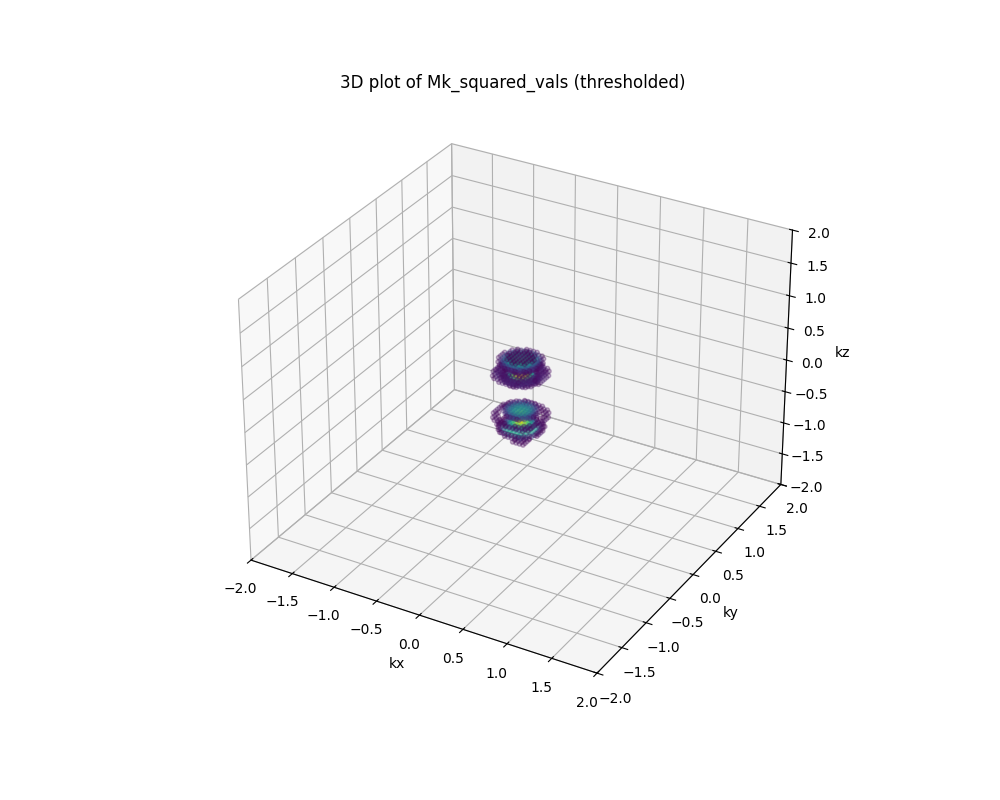

In [13]:
threshold = 0.00005 # or any value you want

# Flatten everything for easy masking
kxs_flat = kxs_grid.flatten()
kys_flat = kys_grid.flatten()
kzs_flat = kzs_grid.flatten()
Mk_flat = Mk_squared_vals.flatten()

mask_slider = widgets.FloatSlider(
    value=threshold,
    min=0,
    max=0.0001,
    step=0.00001,
    description='Threshold',
    continuous_update=False
)
# Create mask for values above threshold

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

def update_plot(threshold):
    ax.cla()  # Clear the previous plot
    mask = Mk_flat > threshold
    # Plot only the points above threshold
    sc = ax.scatter(
        kxs_flat[mask].cpu(), kys_flat[mask].cpu(), kzs_flat[mask].cpu(),
        c=Mk_flat[mask].cpu(), cmap='viridis', marker='o', alpha=0.3, s=10
    )
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])
    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    ax.set_zlabel('kz')
    ax.set_title('3D plot of Mk_squared_vals (thresholded)')


widgets.interactive(update_plot, threshold=mask_slider)